
## Configuración

In [ ]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Colab Notebooks/AprendAuto/Datos/' # Directorio donde guardas los ficheros de datos
except:
  print("Trabajando en local")
  Path = ''                                    # Directorio donde guardas los ficheros de datos

Trabajando en Colab
Mounted at /content/drive


---
## 0. Visualización de datos

Entrenamiento:


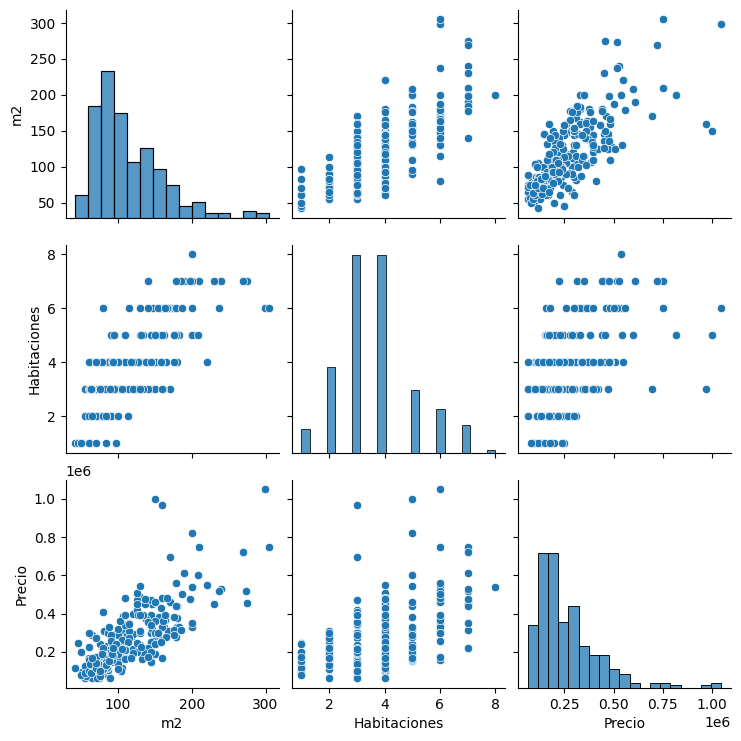

Test:


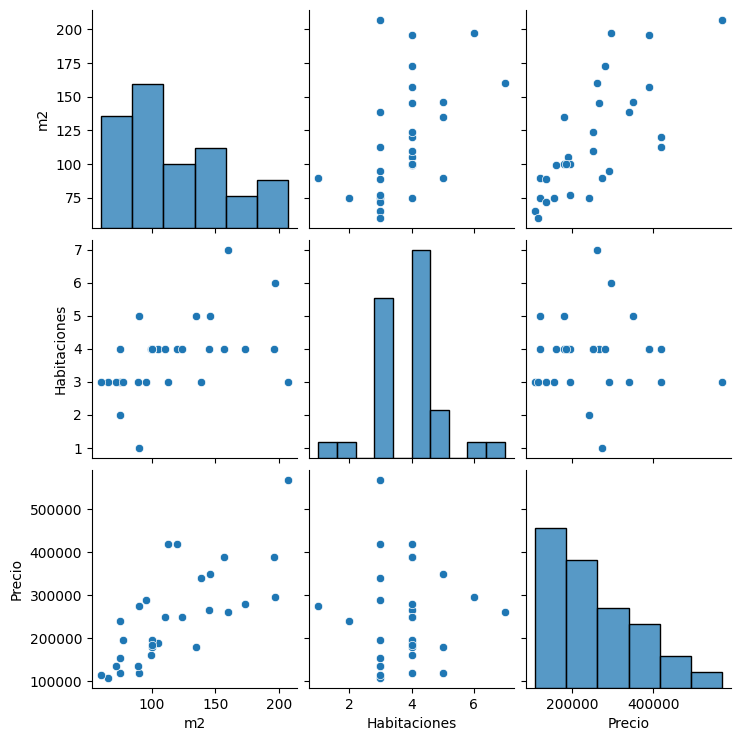

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Leer los ficheros de datos y pasarlos a matrices de numpy
pisos_train = pd.read_csv(Path+'PisosTrain.csv', sep = ";")
x1_train = pisos_train["m2"].to_numpy().reshape(-1, 1)
x2_train = pisos_train["Habitaciones"].to_numpy().reshape(-1, 1)
y_train  = pisos_train["Precio"].to_numpy()

pisos_test  = pd.read_csv(Path+'PisosTest.csv',  sep = ";")
x1_test = pisos_test["m2"].to_numpy().reshape(-1, 1)
x2_test = pisos_test["Habitaciones"].to_numpy().reshape(-1, 1)
y_test  = pisos_test["Precio"].to_numpy()

# Mostrar los datos de entrenamiento
print("Entrenamiento:")
seaborn.pairplot(pisos_train)
plt.show()
print("Test:")
seaborn.pairplot(pisos_test)
plt.show()

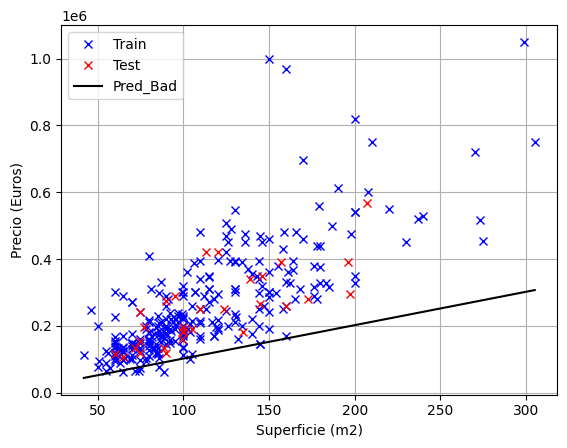

In [ ]:
# Ejemplo de dibujo de un atributo y una prediccion inventada
x1_grid = np.linspace(np.min(x1_train), np.max(x1_train), 100).reshape(-1, 1)
y_grid_pred = x1_grid *1000 + 2000  # Prediccion inventada

plt.figure()
plt.plot(x1_train, y_train, 'bx', label='Train')
plt.plot(x1_test, y_test,  'rx', label='Test')
plt.plot(x1_grid, y_grid_pred, 'k-', label='Pred_Bad')
plt.xlabel('Superficie (m2)')
plt.ylabel('Precio (Euros)')
plt.legend()
plt.grid()
plt.show()

Analizando los datos de la grafica anterior de entrenamiento podemos observar que las unidades de medidas no estan escaladas para poder hacer un analisis mas preciso, es recomendable asignar unidades de medida estandarizadas y escaladas.

1. Habitaciones (Unidades): Se mueve entre 1 y 8.
2. Metros cuadrados ($m^2$): Se mueve entre 40 y 305.
3. Precio: Se mueve entre 60.000 y 1.000.000.(euros)

Por lo cual usaremos mas adelante:
StandardScaler y LinearRegression

Tambien es normal ver que por parte de los datos de entremiento hay muchos valores atipicos puesto que hay gran cantidad de estos frente a los de test.
Pero hay algunos datos espurios que tendremos que tener en cuenta, que han sido añadidos en las ultimas filas y pueden afectar al analisis del modelo. Siendo los pisos mas criticos los de 160 m² y 150 m² sobre el precio de 1000000 de euros. Puesto que no se le pueden asignar ninguna razon aparente a estos valores atipicos con los datos de entrada dados (como podria ser la zona u otras caracteristicas).

---
## 1. Métricas

Vamos a discutir qué métricas de error son adecuadas para este problema, dados los datos de entrada. Prepararemos una función auxiliar para calcular las métricas que analizaremos como más adecuadas para comparar los distintos modelos entre sí. Guardaremos los resultados en un DataFrame de Pandas, con una fila para cada modelo y columnas para las métricas elegidas, facilitándonos el apartado 7.

Como hemos visto anteriormente, la presencia de datos espurios nos ayuda a definir qué medidas serán convenientes para un análisis formal.

Implementaremos el R² por ser el estándar para medir qué parte de la varianza de y es explicada por el modelo. Para evaluar el rendimiento del modelo, implementaremos el Coeficiente de Determinación por ser el estándar estadístico que mide la proporción de la varianza total de la variable dependiente y que es capaz de ser explicada por las variables independientes del modelo.
Matemáticamente, el r2 no representa un porcentaje de aciertos, sino una relación geométrica basada en la Norma Euclídea (L_2). Se define como uno menos el cociente entre la Suma de los Residuos al Cuadrado (la norma al cuadrado del vector de residuos) y la Suma Total de Cuadrados (la varianza total de los datos respecto a su media). Esta formulación implica que el r2 compara la "cantidad de error" que el modelo comete frente al error de un modelo base que predijera simplemente la media. Debido a su dependencia de la norma cuadrática, somos conscientes de que los errores grandes en datos espurios (outliers) se magnificarán al elevarse al cuadrado, afectando desproporcionadamente a la métrica final y penalizando severamente los modelos no robustos."

Puesto que contamos con algunos datos espurios, incluiremos MAE y MRE. Estos representarán la equivocación promedio de euros por piso y en cuánto porcentaje nos desviamos respecto al precio original, respectivamente. Aun con espurios, estas medidas serán excelentes pues, al ser estos minoritarios, no generarán una gran varianza en el resultado.

Añadir MedAE y MedRE nos permite comparar la diferencia con el MAE y el MRE para observar cuánto aumenta la media del error por culpa de los espurios, ya que el MedAE da una visión más realista de lo que falla el modelo en un piso más normal o común.

Aunque el RMSE se vea desviado por la magnitud de los precios (10^6) y los datos espurios, lo mantenemos como métrica de diagnóstico. Su utilidad sera en cuantificar la variabilidad del error; una diferencia amplia entre el RMSE y el MAE es el indicador de que el modelo está sufriendo ante los valores atípicos. No nos servira para decidir cual es mejor o no pero si para un analisis mas informado.

Por último, el coste no se puede usar como métrica ya que depende del tipo de función de coste utilizada, sus unidades son relativas y su valor varía según el número de muestras.

In [ ]:
def calcular_metricas(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  #Sin multivariable al solo hallar y (euros)
  from sklearn.metrics import r2_score
  r2 = r2_score(y_true, y_pred)

  from sklearn.metrics import root_mean_squared_error
  rmse = root_mean_squared_error(y_true, y_pred)

  from sklearn.metrics import mean_absolute_error
  mae = mean_absolute_error(y_true, y_pred)

  from sklearn.metrics import median_absolute_error
  medae = median_absolute_error(y_true, y_pred)

  from sklearn.metrics import mean_absolute_percentage_error
  mre = mean_absolute_percentage_error(y_true, y_pred)

  #No implementado en la libreria sklearn.metrics
  medre = np.median(np.abs((y_true - y_pred) / y_true))

  return r2, rmse, mae, medae, mre, medre

def almacenar_metricas(y_true, y_pred, resultados, tag):
    r2, rmse, mae, medae, mre, medre = calcular_metricas(y_true, y_pred)
    resultados[tag] = [r2, rmse, mae, medae, mre, medre]


----
## 2. Regresión Monovariable con mínimos cuadrados

Vamos a entrenar un modelo de regresión monovariable que prediga el precio de los pisos en función únicamente de su superficie, utilizando mínimos cuadrados convencionales (ecuación normal). Obteniendo la ecuación de la recta de predicción, y su gráfica.

Donde evaluaremos el modelo obtenido y analizaremos los resultados.

Para la implementación del modelo usaremos las funciones de scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).

In [ ]:
from sklearn.linear_model import LinearRegression
resultados = {}
#Definimos el modelo de mínimos cuadrados
Monovar = LinearRegression()
Monovar.fit(x1_train, y_train)

#Sacamos los pesos
w0 = Monovar.intercept_
w1 = Monovar.coef_[0]
print(f"Ecuación: Precio = {w0:.2f} + {w1:.2f} * m2")

# Prediccion del modelo frente a los test
y_pred_mono = Monovar.predict(x1_test)

#Guardar resultados en el diccionario (usando tu función previa), sobreescribiendo resultados
almacenar_metricas(y_test, y_pred_mono, resultados, "Monovariable (LR)")

df_resultados = pd.DataFrame.from_dict(
    resultados,
    orient='index', #indexa Key = Fila
    columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MRE', 'MedRE']
)

display(df_resultados)

Ecuación: Precio = -34313.39 + 2608.21 * m2


,R2,RMSE,MAE,MedAE,MRE,MedRE
Monovariable (LR),0.460891,80628.544728,63936.474539,56182.927196,0.274446,0.259579


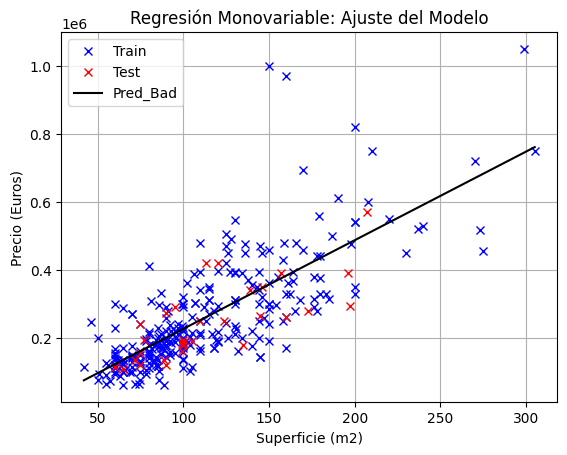

In [ ]:
# Genera 100 puntos entre los valores definidos
x1_grid = np.linspace(np.min(x1_train), np.max(x1_train), 100).reshape(-1, 1)

#Y se los mete a nuestro modelo para saber por donde iria su recta
y_grid_pred = Monovar.predict(x1_grid)

plt.figure()
plt.plot(x1_train, y_train, 'bx', label='Train')
plt.plot(x1_test, y_test,  'rx', label='Test')
plt.plot(x1_grid, y_grid_pred, 'k-', label='Pred_Bad')
plt.xlabel('Superficie (m2)')
plt.ylabel('Precio (Euros)')
plt.title('Regresión Monovariable: Ajuste del Modelo')
plt.legend()
plt.grid()
plt.show()

De forma objetiva el modelo dada su simplicidad aproxima el resultado de forma razonable. Pasa principalmente por el promedio de puntos (resultado de la regresion por minimos cuadrados) pero con un margen de error notrable, podria servir como una simple aproximacion para saber entorno iria su precio pero de forma muy aproximada.

En general con nuestra R^2 = 0.4608 (46%) nos dice que la superficie explica el 46% de la variación en los precios de estas casas. Es una correlación moderada, que sirve para decir "sí, los metros importan", pero insuficiente para predecir con fiabilidad.

Con el MAE de 63,936 € se equivoca por casi 64 mil euros en cada tasación. Y teniendo segun la mediana MedAE 56,183. Donde ordenáramos todos los errores del menor al mayor y cogiéramos el del centro, sería este. Osea evitandonos variaciones generadas por valores atipicos como los mencionados al principio.

Donde comparando el RMSE vs MAE, el RMSE eleva los errores al cuadrado antes de hacer la media, lo que significa que penaliza muchísimo más los errores grandes (los atipicos). Si el modelo se equivocara siempre más o menos lo mismo, el RMSE y el MAE serían parecidos. Donde su diferencia de casi 17,000 entre estos confirma lo que el modelo tiene un problema serio con los valores atípicos (outliers). Cuando falla, a veces falla por cientos de miles de euros, y el RMSE se dispara por culpa de esos casos puntuales.

Para acabar el MRE 0.274 (27.4%) y su hermano el MedRE. Dice que de media el error es un 27.4% del valor real de la casa.
Donde para una casa que vale 200,000. El modelo te dice que podría valer entre ~145,000 € y ~255,000. Ese margen de incertidumbre es demasiado grande para tomar una decisión financiera real pero si aproximada. Donde la ecuacion para una casa de 0 m^2 cuesta -34,313 limitaciones que presenta.

De 50 a 100 m: Los puntos están relativamente cerca de la línea negra.Funciona "regular".

La zona de 150 a 250 m: La dispersión es brutal. Hay puntos azules lejísimos de la línea.

Este modelo pierde precisión dramáticamente a medida que las casas son más grandes. Los errores de 64k o 80k que veíamos en las métricas no están repartidos igual; están concentrados en las casas grandes.

El modelo es incapaz de gestionar la complejidad del mercado, fallando estrepitosamente en las propiedades más grandes y caras, generando un error medio del 27% que lo hace inutilizable para una tasación real. Es imperativo añadir más variables para explicar ese 54% de varianza que nos falta y reducir esos errores catastróficos que inflan el RMSE. Veremos si lo conseguimos con los siguientes modelos.

----
## 3 Regresión Multivariable con mínimos cuadrados


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Preparar los datos multivariable (unir m2 y habitaciones), usamos np.hstack para poner las columnas una al lado de la otra
X_train_multi = np.hstack((x1_train, x2_train))
X_test_multi = np.hstack((x1_test, x2_test))

Multivar = LinearRegression()
Multivar.fit(X_train_multi, y_train)

#Sacamos los pesos
w0 = Multivar.intercept_
w1 = Multivar.coef_[0]
w2 = Multivar.coef_[1]
print(f"Ecuación: Precio = {w0:.2f} + ({w1:.2f} * m2) + ({w2:.2f} * Habitaciones)")

#Prediccion del modelo
y_pred_multi = Multivar.predict(X_test_multi)

#Guardar resultados en el diccionario (usando tu función previa), sobreescribiendo resultados
def almacenar_metricas_ordenado(y_true, y_pred, diccionario, tag):
    r2, rmse, mae, medae, mre, medre = calcular_metricas(y_true, y_pred)
    diccionario[tag] = [r2, rmse, mae, medae, mre, medre]

almacenar_metricas_ordenado(y_test, y_pred_multi, resultados, "Multivariable (LR)")

#Volvemos a visualizar
df_resultados = pd.DataFrame.from_dict(
    resultados,
    orient='index',
    columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MRE', 'MedRE']
)

display(df_resultados)

Ecuación: Precio = -12132.91 + (3028.74 * m2) + (-18852.83 * Habitaciones)


,R2,RMSE,MAE,MedAE,MRE,MedRE
Monovariable (LR),0.460891,80628.544728,63936.474539,56182.927196,0.274446,0.259579
Multivariable (LR),0.536754,74740.529167,55256.440825,36675.141817,0.229578,0.191551


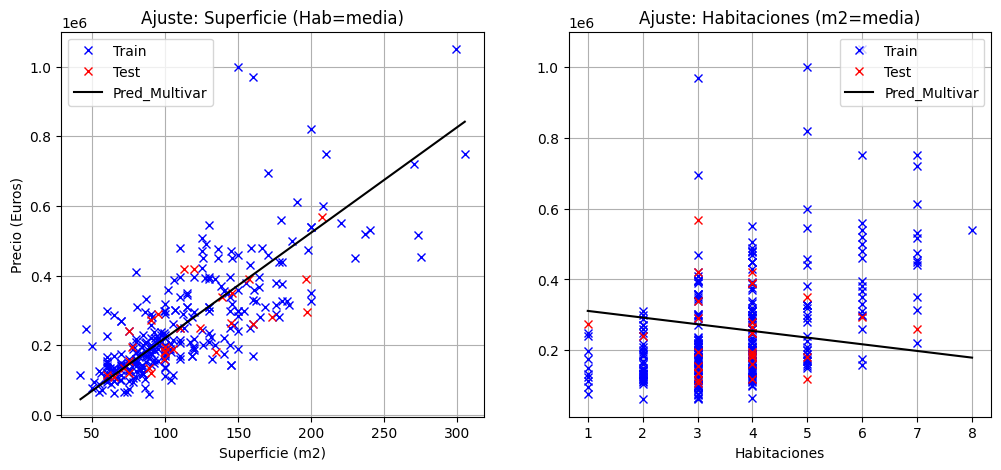

In [ ]:
# Para visualizar el modelo multivariable en 2D, fijamos una variable en su media
# y vemos cómo varía la otra.

# 1. Gráfica para Superficie (m2)
x1_grid = np.linspace(np.min(x1_train), np.max(x1_train), 100).reshape(-1, 1)
# Creamos un bloque de habitaciones con el valor medio para el grid
x2_media = np.full_like(x1_grid, np.mean(x2_train))
grid_multi_m2 = np.hstack((x1_grid, x2_media))
y_grid_pred_m2 = Multivar.predict(grid_multi_m2)

# 2. Gráfica para Habitaciones
x2_grid = np.linspace(np.min(x2_train), np.max(x2_train), 100).reshape(-1, 1)
# Creamos un bloque de superficie con el valor medio para el grid
x1_media = np.full_like(x2_grid, np.mean(x1_train))
grid_multi_hab = np.hstack((x1_media, x2_grid))
y_grid_pred_hab = Multivar.predict(grid_multi_hab)

# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x1_train, y_train, 'bx', label='Train')
plt.plot(x1_test, y_test, 'rx', label='Test')
plt.plot(x1_grid, y_grid_pred_m2, 'k-', label='Pred_Multivar')
plt.xlabel('Superficie (m2)')
plt.ylabel('Precio (Euros)')
plt.title('Ajuste: Superficie (Hab=media)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x2_train, y_train, 'bx', label='Train')
plt.plot(x2_test, y_test, 'rx', label='Test')
plt.plot(x2_grid, y_grid_pred_hab, 'k-', label='Pred_Multivar')
plt.xlabel('Habitaciones')
plt.title('Ajuste: Habitaciones (m2=media)')
plt.legend()
plt.grid()

plt.show()

De forma objetiva el modelo al añadir la variable de habitaciones aproxima el resultado de forma algo más precisa, pero sigue siendo una simplificación. Su línea de tendencia intenta ajustarse mejor al conjunto de puntos (resultado de la regresión multivariable) pero el margen de error sigue siendo notable. Podría servir como una aproximación un poco más "educada" que la anterior al meterle otra variable mas, pero todavía muy orientativa.

Con nuestra R^2 = 0.5367 (53.6%) nos dice que ahora la combinación de superficie y habitaciones explica el 53.6% de la variación en los precios. Es una mejora respecto al 46% anterior, pero tampoco hay un avance exagerado.

Con el MAE de 55,256 euros el modelo se equivoca por unos 55 mil euros de media en cada tasación (hemos bajado casi 9,000 el error respecto al monovariable). Y teniendo según la mediana MedAE 36,675 euros, vemos una mejora muy importante. Al ser la mediana mucho más baja que la media, confirmamos que para la "casa típica" el modelo ahora acierta bastante más, evitando que las variaciones de los valores atípicos empañen tanto el resultado central.

Donde comparando el RMSE (74,740) vs MAE (55,256), el RMSE sigue penalizando mucho más los errores grandes como antes. La diferencia de casi 20,000 entre estos confirma que, aunque hemos mejorado, el modelo sigue teniendo un problema serio con los valores atípicos (outliers).

Para acabar el MRE 0.229 (22.9%) y su hermano el MedRE (19.1%). Dice que de media el error es un 22.9% del valor real de la casa. Es un margen de incertidumbre menor que antes, pero sigue siendo grande para una decisión financiera real.

Cuando fijamos los metros cuadrados, estamos obligando al modelo a comparar los precios en funcion unicamente de las habitaciones.
Donde los metros cuadrados y las habitaciones suelen ser parejos: si uno sube, el otro también.
Como la superficie (m^2) es un predictor tan fuerte, el modelo le da casi todo el peso positivo a los metros. Para "ajustar" los errores, a veces el modelo le da un peso negativo a las habitaciones para compensar los casos donde hay muchos cuartos pero la casa es pequeña. Por cada habitación extra que añadas sin aumentar el tamaño de la casa (dejandolo constante), el precio baja un poco. Si dejasemos un modelo entrenado solo por habitaciones este cogeria parte del papel de la superficie y si que aumentaria junto a este. Pero al no ser el caso nos esta aportando una informacion mas real, independiente a lo que ya sabemos de los m cuadrados.

El modelo ha mejorado pero sigue siendo incapaz de gestionar la complejidad total del mercado, fallando en las propiedades más grandes y caras. Aunque hemos reducido el error medio al 22%, sigue siendo insuficiente para una tasación. Sin mas variables a añadir, veremos como evoluciona en función de la complejidad del modelo.

----
## 4 Regresión Multivariable con descenso de gradiente estocástico


Como comentamos al principio escalar la informacion seria estrictamente necesario, puesto que si no escalamos, el modelo pensará que la superficie es más importante solo porque sus números son más grandes.

Donde para el descenso de gradiente, intenta bajar por  un valle muy estrecho y alargado donde recorrer 1 eje tiene mucha mas prioridad que otro. Para avanzar el eje mas pequeño se le haria mas dificil en funcion del tamaño de paso y otras cosas. Nuestro objetivo es que el valle se vuelve un círculo perfecto. El simplemente camina en línea recta hacia el centro de forma rápida y eficiente.

Con SGD (Descenso de Gradiente), estamos usando un algoritmo iterativo frente a calculos matematicos directos anteriores. Le costaría muchísimo equilibrar la importancia de los metros cuadrados frente a las habitaciones debido a la enorme diferencia de magnitud entre sus valores.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_multi)
X_test_scaled  = scaler.transform(X_test_multi)

Para la implementación del modelo usaremos las funciones de scikit-learn https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

In [ ]:
modelo_sgd = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, random_state=42)
modelo_sgd.fit(X_train_scaled, y_train)

y_pred_sgd = modelo_sgd.predict(X_test_scaled)

almacenar_metricas_ordenado(y_test, y_pred_sgd, resultados, "Multivariable (SGD)")

df_resultados = pd.DataFrame.from_dict(
    resultados,
    orient='index',
    columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MRE', 'MedRE']
)
display(df_resultados)

,R2,RMSE,MAE,MedAE,MRE,MedRE
Monovariable (LR),0.460891,80628.544728,63936.474539,56182.927196,0.274446,0.259579
Multivariable (LR),0.536754,74740.529167,55256.440825,36675.141817,0.229578,0.191551
Multivariable (SGD),0.536757,74740.294924,55696.128694,36994.371725,0.232052,0.198499


Con el modulo PredictionErrorDisplay. El cual a este tipo de modelos perfeciona el analisis que estamos buscando.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PredictionErrorDisplay.html
Donde ambas graficas printan algo parecido uno respecto a la diferencia o error directamente, y el otro cuato se desvian realmente.

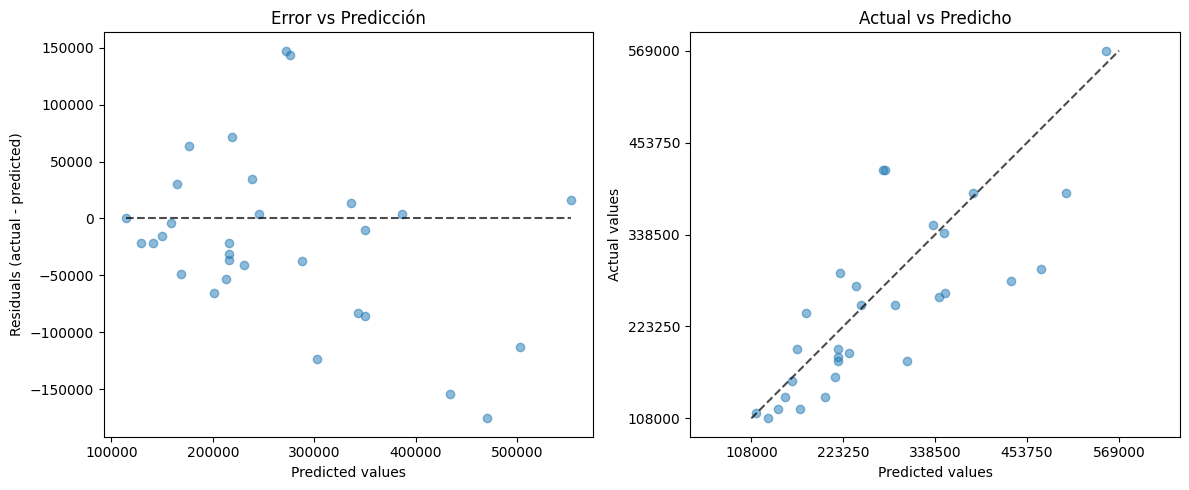

In [ ]:
from sklearn.metrics import PredictionErrorDisplay

# Creamos una figura con dos subgráficas para comparar
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#grafica 1
PredictionErrorDisplay.from_predictions(
    y_test, y_pred_sgd, kind="residual_vs_predicted", ax=ax[0], scatter_kwargs={"alpha": 0.5}
)
ax[0].set_title("Error vs Predicción")

#grafica 2
PredictionErrorDisplay.from_predictions(
    y_test, y_pred_sgd, kind="actual_vs_predicted", ax=ax[1], scatter_kwargs={"alpha": 0.5}
)
ax[1].set_title("Actual vs Predicho")


plt.tight_layout()
plt.show()

De forma objetiva, el paso al modelo multivariable (tanto por mínimos cuadrados como por SGD) Sigue viendo que una línea recta, por muy bien entrenada que esté, tiene un techo de cristal difícil de romper ante la realidad de los datos.

En general, con nuestra r2 clavada en el 0.5367 (53.6%) tanto para el modelo multivariable tradicional como para el de SGD, confirmamos que hemos llegado al límite de lo que una regresión lineal puede extraer de estas dos variables. Haber pasado del 46% del modelo monovariable al 53% es un avance pero no hemos avanzado respecto el paso anterior.

Por lo cual los puntos mencionados en el multivariable LR se siguen aplicando ahora. Pero como novedad si que podemos identificar lo siguiente:

Al mirar la radiografía de los errores en las nuevas gráficas:

Gráfica de Residuos: Confirma que para casas con predicciones de precio bajo (izquierda), los puntos están muy cerca de la línea de cero. Pero a medida que el precio sube, los errores aumentan hacia arriba y hacia abajo. Esto confirma por qué el RMSE (74,740) sigue siendo mucho más alto que el MAE (55,000), el modelo tiene fallos graves en las casas de mayor valor que penalizan brutalmente el promedio.

Actual vs Predicho: La nube de puntos sigue la diagonal, pero se ensancha peligrosamente al final. Demostrando que la relación entre metros, habitaciones y precio no es una línea recta perfecta, los puntos se alejan muchísimo de la línea del cero, tanto por arriba como por abajo. El modelo es incapaz de seguir el ritmo de los precios altos.

Hacer un modelo que siga el ritmo a unos datos tan acotados como estos, bajo mi punto de vista realmente va a ser improbable. El numero de habitaciones y m2 tal vez no sea inforacion suficiente como para predecir la gran cantidad de variaciones que estamos presenciando.

----
## 5 Regresión robusta con coste de Huber

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html

Donde ahora realizaremos una regresión robusta con coste de Huber. Es un modelo híbrido. Para lo normal es preciso, y para lo exagerado es pasota. Por eso se llama Regresión Robusta: porque no permite que un par de casas con precios absurdos arruinen la predicción de las casas normales.

Parece una buena candidata para nuestro dataset porque, como vimos en las graficas de los errores, tenemos puntos que se disparan hacia arriba y hacia abajo y que estaban "engañando" a nuestros modelos anteriores y al ver su diferencia entre M y Med.

In [ ]:
from sklearn.linear_model import HuberRegressor

modelo_huber = HuberRegressor(epsilon=1.35, max_iter=1000)
modelo_huber.fit(X_train_scaled, y_train)

#Predicción
y_pred_huber = modelo_huber.predict(X_test_scaled)

almacenar_metricas_ordenado(y_test, y_pred_huber, resultados, "Huber (Robusta)")

df_resultados = pd.DataFrame.from_dict(
    resultados,
    orient='index',
    columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MRE', 'MedRE']
)
display(df_resultados)

,R2,RMSE,MAE,MedAE,MRE,MedRE
Monovariable (LR),0.460891,80628.544728,63936.474539,56182.927196,0.274446,0.259579
Multivariable (LR),0.536754,74740.529167,55256.440825,36675.141817,0.229578,0.191551
Multivariable (SGD),0.536757,74740.294924,55696.128694,36994.371725,0.232052,0.198499
Huber (Robusta),0.583049,70907.655383,55158.301298,40729.473858,0.220462,0.185632


El parámetro mas importante, epsilon actúa como un umbral de decisión o frontera. Le dice al modelo cuándo dejar de preocuparse por la "precisión milimétrica" (comportamiento cuadrático) y empezar a simplemente "controlar el daño" (comportamiento lineal).

Si el error es menor que epsilon: El modelo asume que es ruido normal. Aplica la norma L2 (al cuadrado).Si el error es mayor que epsilon: El modelo asume que es un outlier. Aplica la norma L1 (valor absoluto), que crece mucho más despacio, impidiendo que ese dato tire de la recta hacia él.

Hemos configurado el parámetro de control epsilon en 1.35. Este valor actúa como el umbral de sensibilidad: determina que cualquier residuo cuyo valor absoluto supere 1.35 desviaciones estándar (sigma) del error estimado será tratado como un valor atípico y penalizado linealmente. Se ha seleccionado este valor estándar (1.35) porque proporciona una eficiencia estadística del 95% en caso de que los datos sigan una distribución normal, logrando un equilibrio óptimo entre robustez frente a anomalías y sensibilidad a la información válida.

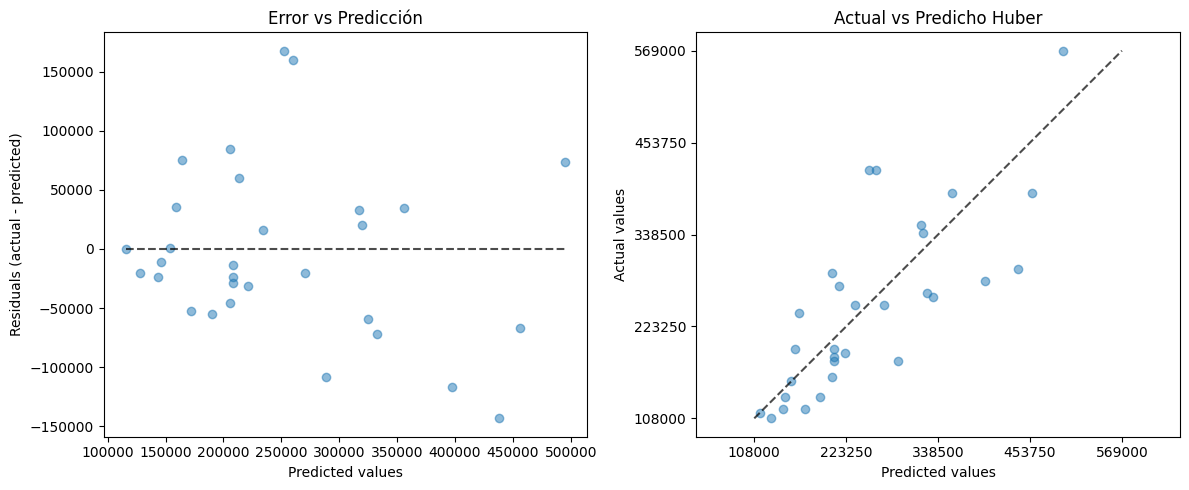

In [ ]:
from sklearn.metrics import PredictionErrorDisplay

# Creamos una figura con dos subgráficas para comparar
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#grafica 1
PredictionErrorDisplay.from_predictions(
    y_test, y_pred_huber, kind="residual_vs_predicted", ax=ax[0], scatter_kwargs={"alpha": 0.5}
)
ax[0].set_title("Error vs Predicción")

#grafica 2
PredictionErrorDisplay.from_predictions(
    y_test, y_pred_huber, kind="actual_vs_predicted", ax=ax[1], scatter_kwargs={"alpha": 0.5}
)
ax[1].set_title("Actual vs Predicho Huber")

plt.tight_layout()
plt.show()

Analizando, el modelo Huber ha logrado finalmente salir del techo que teniamos del 53%, que arrastrábamos con los modelos lineales anteriores. Al actuar como ese criterio que no se deja distraer por los gritos de los precios más absurdos, ha conseguido un ajuste global más sólido, aunque sigue siendo una simplificación.

En general, nuestra R^2 ha subido al 0.5830 (58.3%). Es el avance más significativo que hemos visto hasta ahora, superando por casi 5 puntos el 53.6% del multivariable estándar. Esto nos indica que al dejar de "obsesionarse" con los valores atípicos, el modelo ha encontrado una relación entre metros y habitaciones que explica mejor el comportamiento general del mercado.

Con el MAE de 55,158, el error medio se mantiene casi idéntico al de los modelos anteriores. Sin embargo, el RMSE ha bajado a 70,907 (casi 4,000 menos que el SGD). Esto es clave: al tratar a los outliers de forma lineal y no cuadrática durante el entrenamiento, el modelo Huber ha reducido esos fallos catastróficos que disparaban el RMSE.
Lo curioso es que la mediana del error (MedAE 40,729) ha subido ligeramente respecto a los 36,000 € anteriores. Esto sugiere que el Huber ha sacrificado un poco de puntería en la "casa típica" para ganar una estabilidad mucho mayor en todo el conjunto de datos. Puesto que se centra en los casos mas comunes y su promedio al bajar u mediana tambien lo ha hecho.


Gráfica de Residuos: El efecto de dispersion persiste porque la naturaleza de los datos no ha cambiado, pero la nube de puntos se ve un poco más controlada. El modelo sigue teniendo dificultades en los precios altos (errores hacia arriba y abajo), pero ya no se tuerce tanto intentando cazarlos a todos, lo que se traduce en un RMSE más sano.

Actual vs Predicho: La nube de puntos sigue la diagonal con algo más de determinación. Aunque la dispersión sigue siendo notable (especialmente al final), se nota que el modelo ha dejado de ser priorizar el lujo y ha encontrado un equilibrio más honesto entre los metros y el precio real.

Para acabar, el MRE (22%) y el MedRE (18.5%) muestran una ligera mejora. Seguimos moviéndonos en un margen de error de un quinto del valor de la casa, lo cual, como hemos mantenido desde el principio.

El Huber demuestra que la clave no era solo añadir variables o escalar datos, sino cambiar la forma en que el modelo reacciona ante lo extraño. Hemos estirado la lógica lineal hasta su máximo potencial con este modelo robusto. Como bien sospechábamos, el número de habitaciones y metros no es información suficiente para la precisión total, pero el Huber es el que mejor ha sabido gestionar un poco esta carencia frente a sus competidores. Veremos si con una red nueronal seria y bien entrenada conseguimos sacar algo mejor, pero sin unos buenos datos jamas obtendremos un buen modelo.

----
## 6 Redes neuronales

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Tras exprimir la lógica lineal con el modelo Huber, llegamos a una conclusión: la línea recta tiene un límite. Para intentar romper ese techo del 58%, introducimos las Redes Neuronales (Multi-Layer Perceptron).

La idea es dejar de forzar que el precio suba de forma proporcional a los metros y permitir que el modelo aprenda relaciones complejas y curvas. Una red neuronal puede entender que una habitación extra en un piso pequeño vale mucho, pero en una mansión de 500 m2 es casi irrelevante.

Entrenamos dos versiones: una "básica" (sin capas ocultas) para validar la teoría y una "inteligente" (con 12 neuronas y activación ReLU) para buscar la precisión.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import pandas as pd

# 1. ESCALADO DE LA 'Y' (PRECIO) - Vital para Redes Neuronales
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# MODELO 6.1: NN SIN CAPA OCULTA (Equivalente a Regresión Lineal)
# Al poner hidden_layer_sizes=() y activation='identity', las entradas
nn_linear = MLPRegressor(
    hidden_layer_sizes=(),
    activation='identity',
    solver='lbfgs',
    alpha=0.01,
    max_iter=5000,
    random_state=0
)

nn_linear.fit(X_train_scaled, y_train_scaled)
pred_lin_scaled = nn_linear.predict(X_test_scaled)
y_pred_euros_lin = scaler_y.inverse_transform(pred_lin_scaled.reshape(-1, 1)).ravel()
almacenar_metricas_ordenado(y_test, y_pred_euros_lin, resultados, "NN (Sin capa oculta)")

# MODELO 6.2: NN CON 1 CAPA OCULTA (No Lineal)
nn_hidden = MLPRegressor(
    hidden_layer_sizes=(128,),
    activation='identity',
    solver='lbfgs',
    alpha=10,
    learning_rate_init=0.1,
    max_iter=1000,
    early_stopping=True,
    random_state=0
)

nn_hidden.fit(X_train_scaled, y_train_scaled)
pred_hid_scaled = nn_hidden.predict(X_test_scaled)
y_pred_euros_hid = scaler_y.inverse_transform(pred_hid_scaled.reshape(-1, 1)).ravel()
almacenar_metricas_ordenado(y_test, y_pred_euros_hid, resultados, "NN (1 capa oculta)")

# Mostramos la tabla definitiva para el análisis
df_resultados = pd.DataFrame.from_dict(resultados, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MRE', 'MedRE'])
display(df_resultados)

,R2,RMSE,MAE,MedAE,MRE,MedRE
Monovariable (LR),0.460891,80628.544728,63936.474539,56182.927196,0.274446,0.259579
Multivariable (LR),0.536754,74740.529167,55256.440825,36675.141817,0.229578,0.191551
Multivariable (SGD),0.536757,74740.294924,55696.128694,36994.371725,0.232052,0.198499
Huber (Robusta),0.583049,70907.655383,55158.301298,40729.473858,0.220462,0.185632
NN (Sin capa oculta),0.536720,74743.300580,55263.662775,36691.096501,0.229628,0.191719
NN (1 capa oculta),0.533409,75009.948629,58803.931002,45598.294112,0.252387,0.238781


Donde para visualizar si realmente se produce sobreentrenamiento o no usaremos esta grafica de scikit learn (https://scikit-learn.org/stable/modules/learning_curve.html). Otra opcion podria hacer sido graficar tambien los datos de los analisis de entrenamiento para realizar una comparacion directa de resultados, permitiendonos observar si hay una gran diferencia entre el test y entrenamiento (definicion caracteristica del sobreajuste o mal entrenamiento, al no converger de la mano).

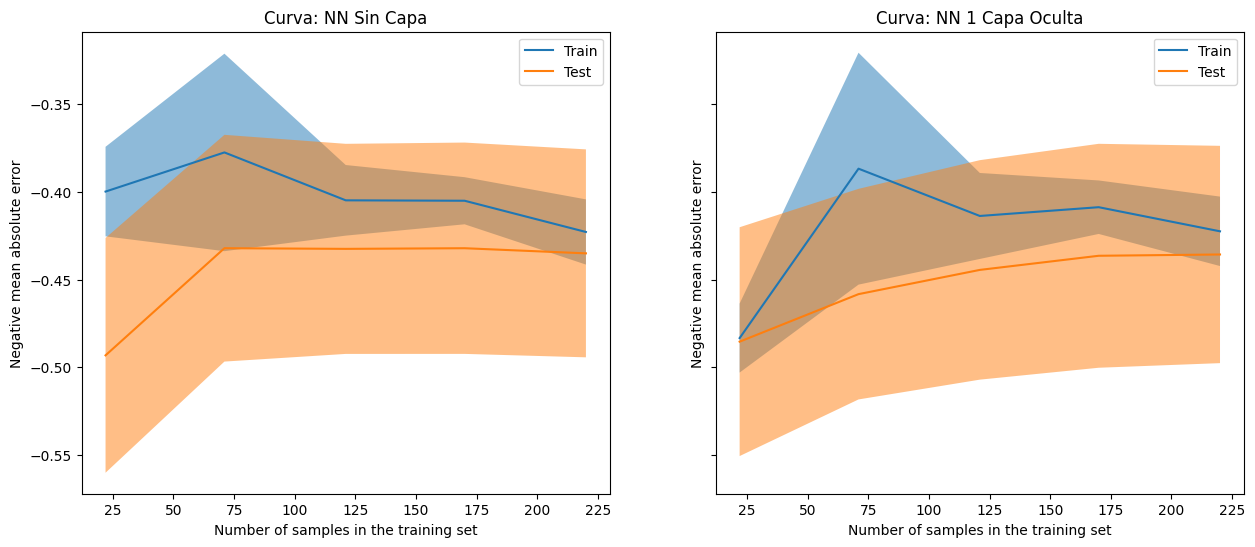

In [ ]:
from sklearn.model_selection import LearningCurveDisplay
import matplotlib.pyplot as plt

# Configuramos la comparativa
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# 1. Curva para el Modelo Lineal (Sin capa)
LearningCurveDisplay.from_estimator(
    nn_linear, X_train_scaled, y_train_scaled,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="neg_mean_absolute_error", # Usamos error para ver el "gap"
    ax=ax[0]
)
ax[0].set_title("Curva: NN Sin Capa")

# 2. Curva para el Modelo con Capa Oculta
LearningCurveDisplay.from_estimator(
    nn_hidden, X_train_scaled, y_train_scaled,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="neg_mean_absolute_error",
    ax=ax[1]
)
ax[1].set_title("Curva: NN 1 Capa Oculta")

plt.show()

implementamos redes neuronales para intentar capturar relaciones no lineales que los modelos anteriores ignoraban. Sin embargo, los resultados nos cuentan una historia de rendimientos decrecientes:

NN (Sin capa oculta): R^2 = 0.5367 al no tener capas intermedias, la red se comporta como una regresión lineal multivariable pura. El resultado es idéntico al modelo lineal, confirmando que el motor de optimización (lbfgs) ha llegado a la solución óptima para una línea recta.

NN (1 capa oculta): R^2 = 0.5323 . Al usar 128 neuronas, ReLU y un alpha=10, castigamos tanto a la red que la obligamos a ser conservadora. Aunque tiene capacidad de curvarse, el freno (alpha) es tan fuerte que se queda pegada al suelo de la regresión lineal, sin llegar a superarla. Todas las pruebas hechas anteriormente con la capa oculta solo saca un buen rendimiento si trata de plagiar a la sin capa oculta, aproximandose a su valor. Lo que quiere decir que la resolucion optima para una red Neuronal es aproximarse a la recta original generada por la anterior. Osea no es un problema de complegidad o analisis que pueda ser interpretado por una red neuronal. Es un problema enteramente de los datos de entrada.
El fallo de la No-Linealidad se debe al intentar usar ReLU (curvas), el error empeoró o se estancó, teniendo que tirar del freno de mano de alpha (esta colapsa en una Regresión Lineal). La relación entre metros y precio en tu zona de estudio es fundamentalmente lineal. Intentar buscar "curvas" donde no las hay solo produce sobreentrenamiento (el modelo se aprende de memoria el ruido del Excel).

----
## 7 Resumen de las conclusiones

 El ganador absoluto es el Modelo Huber (R^2 = 0.5830). En esta entrada con presencia de valores atípicos (outliers), el coste de Huber demuestra ser superior a la norma L_2 convencional. Al ponderar de forma lineal los errores grandes en lugar de cuadrática, el modelo evita ser arrastrado por los precios extremos, logrando una generalización mucho más sólida.

Es la prueba de que, para este dataset, gestionar los errores es más importante que tener muchas neuronas.

El Techo de Cristal de los Datos hemos observado que pasar de 1 variable a 2 mejoró mucho el modelo. Pero pasar de una línea a una Red Neuronal compleja no ha servido de nada. Hemos llegado al límite de información de los metros cuadrados y las habitaciones. El 40% que nos falta para llegar al 1.0 de precisión no está en el algoritmo, sino en los datos que no tenemos.

Ademas los modelos basados en la Ecuación Normal y L-BFGS son extremadamente eficientes y rápidos, estableciendo el "suelo" de rendimiento en un 53.6%.
El descenso de gradiente (SGD) con escalado de datos logra resultados idénticos, validando la convergencia de ambos métodos.

Si un modelo complejo (NN) no logra superar estas métricas base como nos ha pasado, debe ser descartado en favor de la simplicidad y la interpretabilidad.

La NN sin capa oculta actúa, por definición, como una regresión lineal multivariable pura.

Las redes neuronales son significativamente más costosas en tiempo y recursos. En este escenario, su uso no está justificado, ya que el modelo Huber ofrece mejores métricas con una fracción del costo computacional y una robustez muy superior ante datos espurios.

Para este problema de tasación, la clave del éxito no ha sido aumentar el número de neuronas, sino gestionar el ruido de los datos. El modelo Huber es la herramienta más fiable para esto. Es la confirmación definitiva de que, sin nuevas variables la red neuronal más compleja del mundo solo puede aspirar a empatar con una línea recta bien tirada.